<a id=contents></a>

# Cleaning notebook
## Subtitle


[1. Data Inspection](#insp)

[2. Cleaning numerical data](#numerical)

[3. Cleaning categorical data](#categ)

[4. Cleaning text data](#text)

In [1]:

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

Let's load up the data and answer:
* how many sentences and words do we have?
* What is the distribution of NE tags?
* What is the distribution of Part of Sentence (POS) tags?

In [6]:
df = pd.read_csv('GMB_dataset.txt', sep='\t' , encoding='unicode_escape').drop(columns=['Unnamed: 0'])
df.head()

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


In [8]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66161 entries, 0 to 66160
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sentence #  66161 non-null  float64
 1   Word        66161 non-null  object 
 2   POS         66161 non-null  object 
 3   Tag         66161 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [10]:
df['Sentence #'].nunique()

2999

So we have over 66 thousand words to look at amongst just under 3000 sentences, each with  Part of Sentence (POS) tag and an NE tag.

In [27]:
pos_dist = df.POS.value_counts(normalize=True)
print(pos_dist.index)

Index(['NN', 'NNP', 'IN', 'DT', 'JJ', 'NNS', '.', 'VBD', 'VBN', ',', 'VBZ',
       'VB', 'CC', 'CD', 'TO', 'RB', 'VBG', 'VBP', 'PRP', 'POS', 'PRP$', 'MD',
       '``', 'WDT', 'JJR', 'JJS', 'WP', 'WRB', 'NNPS', 'RP', 'RBR', '$', ':',
       'RRB', 'EX', 'LRB', ';', 'RBS', 'PDT', 'WP$', 'UH'],
      dtype='object')


We have 41 POS categories. I've included a table below that was adapted from *Natural Language Processing with Python*, by Steven Bird, Ewan Klein and Edward Loper. [Link to specific chapter](https://www.nltk.org/book/ch05.html)

|Tag | Meaning | English Examples |
| :---| :----- | :--------------- | 
|JJ  | adjective | new, good, high
| JJR| Adjective, comparative | newer, better, higher
| JJS| Adjective, superlative | newest, best, highest
| MD | Modal | can, must, will, may
|IN  | Preposition or subordinating conjunction | on, of, at, with, by, into , under
| CC | Coordinating conjunction | but, and, for, nor
| CD | Cardinal number | one, 2, fifty, a thousand
| TO | to | to
| FW| Foreign word | rendez-vous, schadenfreude
| EX| Existential there | e.g. "There is a place ..."
| PDT| Predeterminer | both, all
| POS| Possessive ending | 's
| PRP| Personal pronoun | he, she, they
| PRP\$ | Possessive pronoun | mine, yours, theirs, hers
| ADV| adverb |really, already, still, early, now
| DT | Determiner | the, a, an
| VB | Verb, base form | buy, strike, burrow
| VBD| Verb, past tense | bought, striked, burrowed
| VBG| Verb, gerund or present participle | buying, striking, burrowing
| VBN| Verb, past participle | (was) buying, (was) striking, (was) burrowing
| VBP| Verb, non-3rd person singular present | buy, strike, burrown
| VBZ| Verb, 3rd person singular present | buys, strikes, burrows
| RB | Adverb | quickly, meekly, loudly
| RBR| Adverb, comparative | quicker, meaker, louder
| RBS| Adverb, superlative | quickest, meekest, loudest
| WDT| Wh-determiner | who, what, when, where
|DET| determiner, article | the, a, some, most, every, no, which
|NN| noun, singular or mass | year, home, cost, time,
|NNP| proper noun, singular | Africa, John, Bush
|NNS| noun, plural | sheep, buckets, persons
| NNPS | Proper noun, plural| Grammys, Oscars
|\$| numeral |twenty-four, fourth, 1991, 14:24
|RP| particle | at, on, out, over per, that, up, with
| WP| Wh-pronoun | who, whether, which
| WP$| Possessive wh-pronoun | whose
| WRB| Wh-adverb | whence, where, why
| LS| List item marker | 
| UH| Interjection | hey, yo, huzzah
| LRB | Open parenthesis | (, [, {
| RRB | Close parenthesis | ), ], }
|. | punctuation marks | . , ; !
|X | other | ersatz, esprit, dunno, gr8, univeristy



Upon immediate inspection, there are some categories that are redundant (specifically ',' , '\`' and ';'). Since they're all clearly punctuation that aren't part of a list marking, I'll be reallocating their values to be the same as the POS tag for punctuation - '.'. This won't lose too much information if you consider that the original content will still be maintained, namely the actual punctuation in and of itself. 

<a id=numerical ><a/> 

## 2. Cleaning data
    
[LINK to table of contents](#contents)

In [32]:
for i in [',', '`', ';', '``']:
    df.loc[df.POS == i, 'POS'] = '.'
    
df.POS.value_counts()

NN      9307
NNP     8189
IN      7759
DT      6310
.       5208
JJ      4875
NNS     4803
VBD     2429
VBN     2060
VBZ     1644
VB      1538
CC      1475
CD      1474
TO      1449
RB      1324
VBG     1180
VBP     1028
PRP      887
POS      694
PRP$     533
MD       454
WDT      209
JJR      198
JJS      179
WP       158
WRB      153
NNPS     146
RP       143
RBR       77
$         61
:         54
RRB       43
EX        43
LRB       43
RBS       16
PDT       12
WP$        5
UH         1
Name: POS, dtype: int64

In [34]:
pos_dist = df.POS.value_counts(normalize=True)
len(pos_dist.index)

38

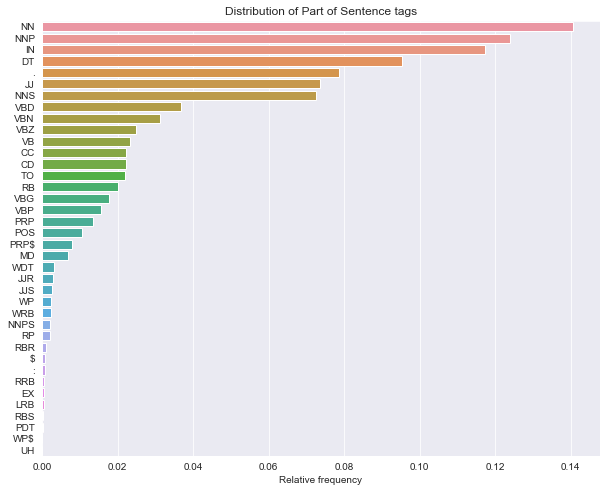

In [37]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Part of Sentence tags')
sns.barplot(y = pos_dist.index, x= pos_dist.values, )
plt.xlabel('Relative frequency');

So we can see now that we've got quite a skewed POS distribution, primarily skewed towards nouns. We'll explore this in more detail in notebook 3. For now let's save the cleaned data. 

<a id=text ><a/> 

## 3. Saving clean data
    
[LINK to table of contents](#contents)

In [122]:
df.to_csv('clean_data/clean_data.csv')